# Process dataset

In [1]:
import pandas as pd
import numpy as np

Download dataset

In [2]:
df = pd.read_csv('BFO.csv')
df.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-09-29,15.01,15.01,15.00,15.01,7.686016,17100
1,2003-09-30,15.00,15.01,15.00,15.01,7.686016,2200
2,2003-10-01,15.01,15.01,15.00,15.01,7.686016,9100
3,2003-10-02,15.01,15.01,15.01,15.01,7.686016,3900
4,2003-10-03,15.01,15.01,15.01,15.01,7.686016,1300
5,2003-10-06,15.05,15.05,15.01,15.05,7.706499,9700
6,2003-10-07,15.00,15.01,15.00,15.00,7.680897,12700
7,2003-10-08,15.00,15.00,15.00,15.00,7.680897,0
8,2003-10-09,15.01,15.01,15.00,15.01,7.686016,15700
9,2003-10-10,15.01,15.07,15.01,15.07,7.716740,1500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4156 non-null   object 
 1   Open       4156 non-null   float64
 2   High       4156 non-null   float64
 3   Low        4156 non-null   float64
 4   Close      4156 non-null   float64
 5   Adj Close  4156 non-null   float64
 6   Volume     4156 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 227.4+ KB


Check data types

In [4]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
import matplotlib.pyplot as plt

def plot_autocorrelation(series, max_lag):
    autocorr_values = [series.autocorr(lag) for lag in range(max_lag)]
    plt.figure(figsize=(10, 6))
    plt.stem(range(max_lag), autocorr_values)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Plot')
    plt.show()

Visualize the autocorrelation value at different lag values ​​for the target variable

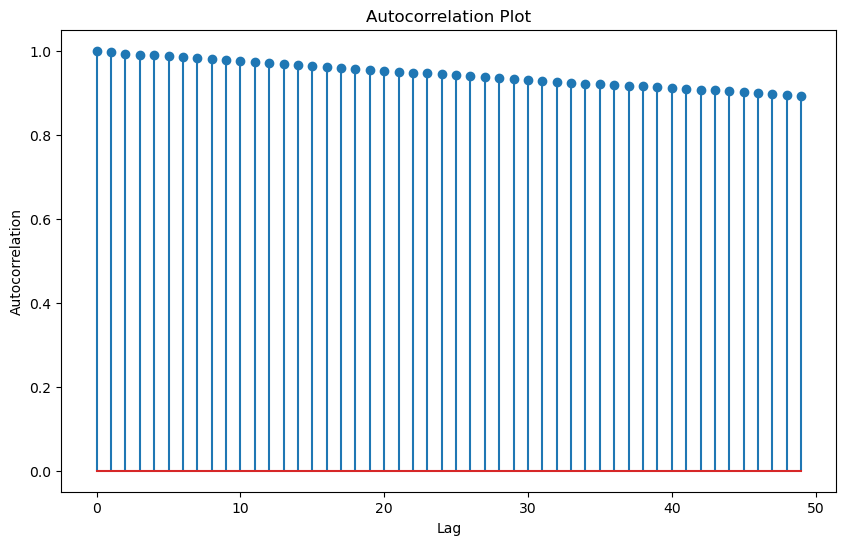

In [ ]:
close_series = df['Close']

plot_autocorrelation(close_series, max_lag=50)

<Axes: >

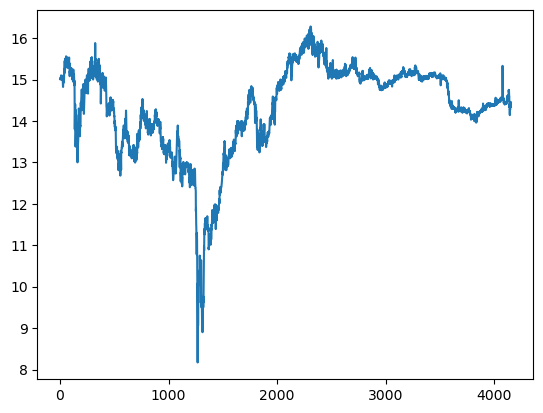

In [7]:
close_series.plot()

For walk forward methodology, we will use its Rolling subtype

In [8]:
def walk_forward(close_values, sliding_window_size):
    close_values = close_values.to_numpy()

    X = [close_values[i:i + sliding_window_size] for i in range(len(close_values) - sliding_window_size - 1)]
    y = [close_values[i+sliding_window_size] for i in range(len(close_values) - sliding_window_size - 1)]
    
    return X, y

Several values ​​were tested for sliding_window_size, but the current value showed the best results

In [9]:
X, y = walk_forward(df['Close'].copy(), 8)

Let's divide the data into training and test data in the ratio of 8:2

In [10]:
separator = int(df['Close'].shape[0] * 0.8)

In [11]:
X_train, X_test = X[:separator], X[separator:]
y_train, y_test = y[:separator], y[separator:]

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

3324
823
3324
823


In [12]:
dc = df[['Date', 'Close']].copy(deep=True)

In [13]:
dc = dc[separator:]
dc = dc.rename(columns={"Date":"ds","Close":"y"})
dc

,ds,y
3324,2016-12-09,15.02
3325,2016-12-12,14.97
3326,2016-12-13,15.08
3327,2016-12-14,15.08
3328,2016-12-15,15.02
...,...,...
4151,2020-03-26,14.35
4152,2020-03-27,14.36
4153,2020-03-30,14.46
4154,2020-03-31,14.43


# Additional functions

In [14]:
from prophet.plot import plot_plotly
from prophet import Prophet

def prophet_plotting(dc, test_predictions):
    prophet_model = Prophet()
    prophet_model.fit(dc)

    # Make predictions
    future = prophet_model.make_future_dataframe(periods=len(test_predictions))
    forecast = prophet_model.predict(future)

    # Plot the forecast
    fig = plot_plotly(prophet_model, forecast)
    fig.show()

# LR

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

R2 score: 0.9783745743717813
Test RMSE: 0.052452367527086936


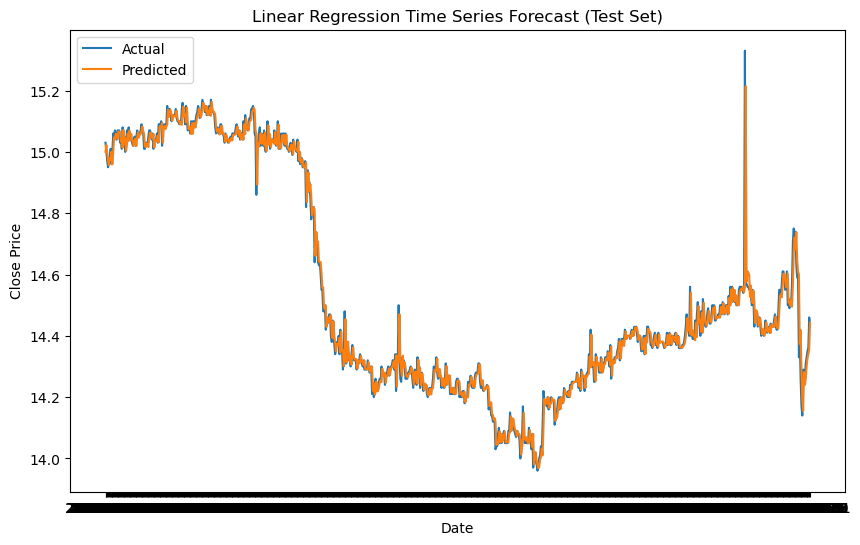

In [ ]:
lr_model = LinearRegression()

lr_history = lr_model.fit(X_train, y_train)

lr_test_predictions = lr_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_predictions))
r2 = r2_score(y_test, lr_test_predictions)

print(f"R2 score:", r2)
print("Test RMSE:", test_rmse)

plt.figure(figsize=(10, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], lr_test_predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression Time Series Forecast (Test Set)')
plt.legend()
plt.show()

In [90]:
prophet_plotting(dc, lr_test_predictions)

20:34:50 - cmdstanpy - INFO - Chain [1] start processing
20:34:50 - cmdstanpy - INFO - Chain [1] done processing


# RF

R2 score: 0.9713909804779056
Test RMSE: 0.06033012854489516


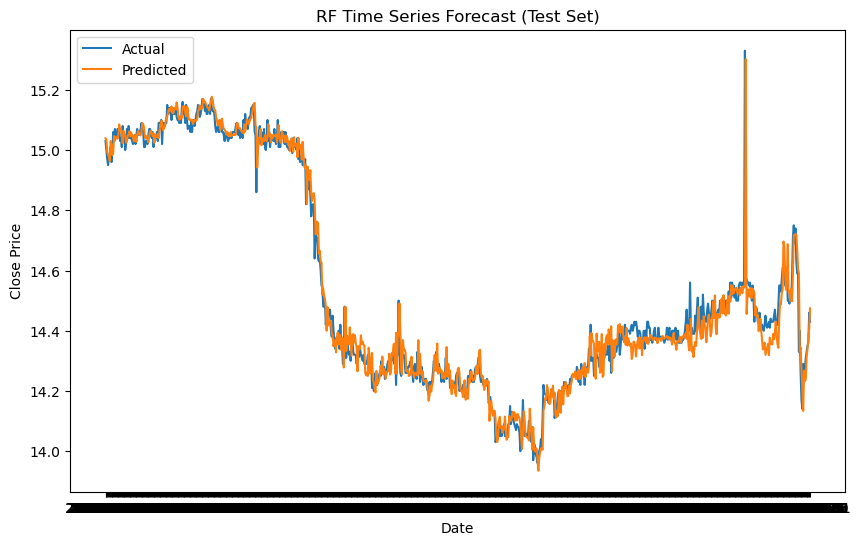

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=500)

rf_history = rf_model.fit(X_train, y_train)

rf_test_predictions = rf_model.predict(X_test)

test_rmse_rf = np.sqrt(mean_squared_error(y_test, rf_test_predictions))
r2_rf = r2_score(y_test, rf_test_predictions)

print(f"R2 score:", r2_rf)
print("Test RMSE:", test_rmse_rf)

plt.figure(figsize=(10, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], rf_test_predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('RF Time Series Forecast (Test Set)')
plt.legend()
plt.show()

In [164]:
prophet_plotting(dc, rf_test_predictions)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\rabot\AppData\Local\Temp\tmp7bga5ba_\0m5nex_f.json
DEBUG:cmdstanpy:input tempfile: C:\Users\rabot\AppData\Local\Temp\tmp7bga5ba_\sdj0_w52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['D:\\Anaconda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=57606', 'data', 'file=C:\\Users\\rabot\\AppData\\Local\\Temp\\tmp7bga5ba_\\0m5nex_f.json', 'init=C:\\Users\\rabot\\AppData\\Local\\Temp\\tmp7bga5ba_\\sdj0_w52.json', 'output', 'file=C:\\Users\\rabot\\AppData\\Local\\Temp\\tmp7bga5ba_\\prophet_modeleziexq8f\\prophet_model-20240512210349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:03:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [

# LSTM + DNN

In [15]:
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam 

In [16]:
for l in X_train:
    l = np.array(l)

for l in X_test:
    l = np.array(l)

X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [17]:
train_X = np.reshape(X_train, (len(X_train), len(X_train[0]), 1))
test_X = np.reshape(X_test, (len(X_test), len(X_test[0]), 1))

In [18]:
lstm_dnn_model = Sequential()
lstm_dnn_model.add(layers.LSTM(256, input_shape=(8,1), return_sequences=True))
lstm_dnn_model.add(layers.Dropout(0.3))
lstm_dnn_model.add(layers.LSTM(128))
lstm_dnn_model.add(layers.Dropout(0.5))
lstm_dnn_model.add(layers.Dense(1, activation='linear'))
lstm_dnn_model.compile(loss="mse", optimizer=Adam(lr=0.001))
lstm_dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 256)            264192    
                                                                 
 dropout (Dropout)           (None, 8, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 461441 (1.76 MB)
Trainable params: 461441 (1.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
lstm_dnn_history = lstm_dnn_model.fit(train_X, y_train, epochs=30, batch_size=32) # best e=30, bs=32

Epoch 1/30
104/104 [==============================] - 3s 28ms/step - loss: 0.9714
Epoch 2/30
104/104 [==============================] - 3s 26ms/step - loss: 0.9163
Epoch 3/30
104/104 [==============================] - 3s 28ms/step - loss: 0.9415
Epoch 4/30
104/104 [==============================] - 3s 27ms/step - loss: 0.9220
Epoch 5/30
104/104 [==============================] - 3s 28ms/step - loss: 0.9220
Epoch 6/30
104/104 [==============================] - 3s 30ms/step - loss: 0.9135
Epoch 7/30
104/104 [==============================] - 3s 27ms/step - loss: 0.9617
Epoch 8/30
104/104 [==============================] - 3s 27ms/step - loss: 0.9305
Epoch 9/30
104/104 [==============================] - 3s 26ms/step - loss: 0.8385
Epoch 10/30
104/104 [==============================] - 3s 26ms/step - loss: 0.8474
Epoch 11/30
104/104 [==============================] - 3s 27ms/step - loss: 0.8609
Epoch 12/30
104/104 [==============================] - 3s 26ms/step - loss: 0.8683
Epoch 13/30
1

In [ ]:
lstm_dnn_predictions = lstm_dnn_model.predict(test_X)

26/26 [==============================] - 0s 10ms/step


R2 score: 0.9662215742725108
Test RMSE: 0.06555449349075078


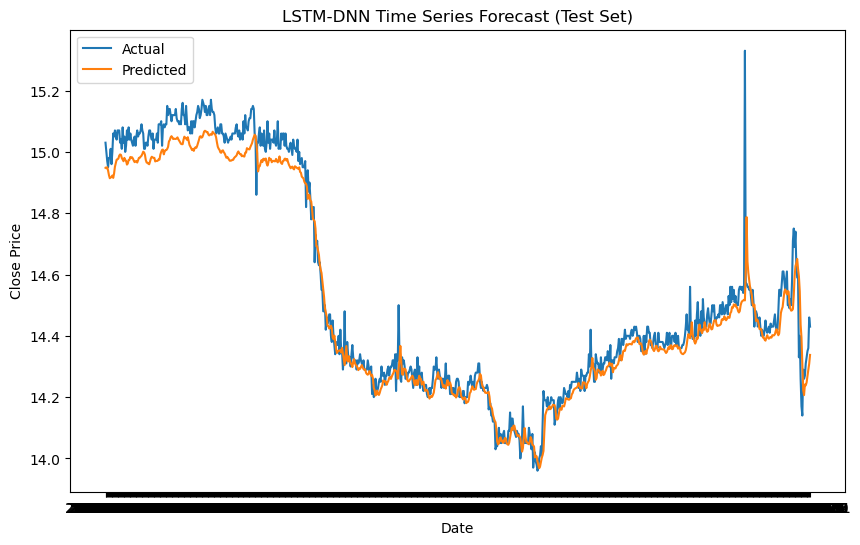

In [ ]:
lstm_dnn_test_rmse = np.sqrt(mean_squared_error(y_test, lstm_dnn_predictions))
lstm_dnn_r2 = r2_score(y_test, lstm_dnn_predictions)

print(f"R2 score:", lstm_dnn_r2)
print("Test RMSE:", lstm_dnn_test_rmse)

plt.figure(figsize=(10, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], lstm_dnn_predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM-DNN Time Series Forecast (Test Set)')
plt.legend()
plt.show()

In [30]:
prophet_plotting(dc, lstm_dnn_predictions)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\rabot\AppData\Local\Temp\tmphzgc_vzi\2qi_fpy6.json
DEBUG:cmdstanpy:input tempfile: C:\Users\rabot\AppData\Local\Temp\tmphzgc_vzi\157pha9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['D:\\Anaconda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=91904', 'data', 'file=C:\\Users\\rabot\\AppData\\Local\\Temp\\tmphzgc_vzi\\2qi_fpy6.json', 'init=C:\\Users\\rabot\\AppData\\Local\\Temp\\tmphzgc_vzi\\157pha9t.json', 'output', 'file=C:\\Users\\rabot\\AppData\\Local\\Temp\\tmphzgc_vzi\\prophet_model7b4bum6c\\prophet_model-20240512221436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [

# 1D-CNN-LSTM-DNN

In [ ]:
cnn_lstm_dnn_model = Sequential()
cnn_lstm_dnn_model.add(layers.Conv1D(filters=3, kernel_size=8, strides=1, activation='relu', padding='same', input_shape=(8, 1)))
cnn_lstm_dnn_model.add(layers.Conv1D(filters=3, kernel_size=8, strides=1, activation='relu', padding='same'))
cnn_lstm_dnn_model.add(layers.LSTM(256, return_sequences=True))
cnn_lstm_dnn_model.add(layers.Dropout(0.3))
cnn_lstm_dnn_model.add(layers.LSTM(128))
cnn_lstm_dnn_model.add(layers.Dropout(0.5))
cnn_lstm_dnn_model.add(layers.Dense(1, activation='linear'))

cnn_lstm_dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
cnn_lstm_dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 3)              27        
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 3)              75        
                                                                 
 lstm_2 (LSTM)               (None, 8, 256)            266240    
                                                                 
 dropout_2 (Dropout)         (None, 8, 256)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
cnn_lstm_dnn_history = cnn_lstm_dnn_model.fit(train_X, y_train, epochs=30, batch_size=64)

Epoch 1/30
52/52 [==============================] - 2s 39ms/step - loss: 1.0447
Epoch 2/30
52/52 [==============================] - 2s 36ms/step - loss: 1.0733
Epoch 3/30
52/52 [==============================] - 2s 35ms/step - loss: 1.1364
Epoch 4/30
52/52 [==============================] - 2s 36ms/step - loss: 1.0645
Epoch 5/30
52/52 [==============================] - 2s 40ms/step - loss: 1.1100
Epoch 6/30
52/52 [==============================] - 2s 39ms/step - loss: 1.0381
Epoch 7/30
52/52 [==============================] - 2s 38ms/step - loss: 1.0344
Epoch 8/30
52/52 [==============================] - 2s 43ms/step - loss: 1.0529
Epoch 9/30
52/52 [==============================] - 2s 39ms/step - loss: 1.2122
Epoch 10/30
52/52 [==============================] - 2s 38ms/step - loss: 1.1135
Epoch 11/30
52/52 [==============================] - 2s 37ms/step - loss: 1.0011
Epoch 12/30
52/52 [==============================] - 2s 36ms/step - loss: 1.0554
Epoch 13/30
52/52 [==================

In [ ]:
cnn_lstm_dnn_predictions = cnn_lstm_dnn_model.predict(test_X)

26/26 [==============================] - 0s 9ms/step


R2 score: 0.9618214839824576
Test RMSE: 0.06969350162240132


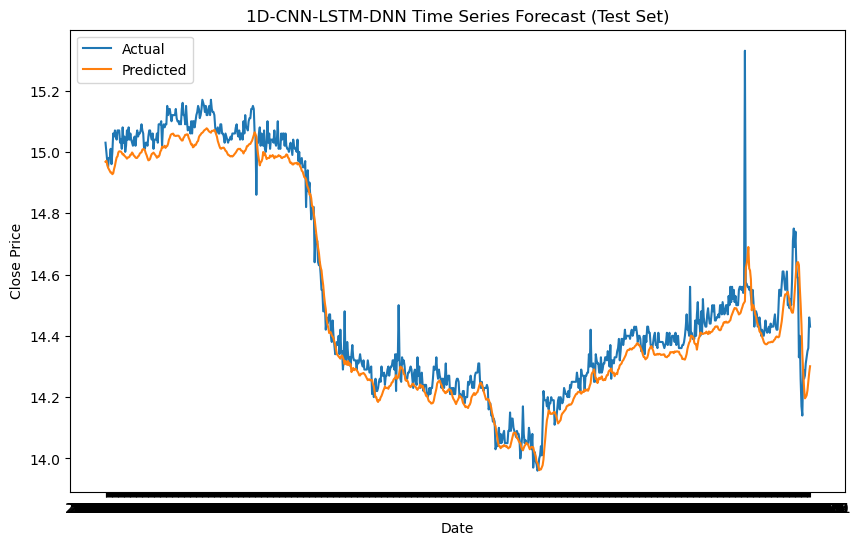

In [ ]:
cnn_lstm_dnn_test_rmse = np.sqrt(mean_squared_error(y_test, cnn_lstm_dnn_predictions))
cnn_lstm_dnn_r2 = r2_score(y_test, cnn_lstm_dnn_predictions)

print(f"R2 score:", cnn_lstm_dnn_r2)
print("Test RMSE:", cnn_lstm_dnn_test_rmse)

plt.figure(figsize=(10, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], cnn_lstm_dnn_predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('1D-CNN-LSTM-DNN Time Series Forecast (Test Set)')
plt.legend()
plt.show()

In [42]:
prophet_plotting(dc, cnn_lstm_dnn_predictions)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\rabot\AppData\Local\Temp\tmphzgc_vzi\o6quo9q_.json
DEBUG:cmdstanpy:input tempfile: C:\Users\rabot\AppData\Local\Temp\tmphzgc_vzi\jr41j27u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['D:\\Anaconda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=39710', 'data', 'file=C:\\Users\\rabot\\AppData\\Local\\Temp\\tmphzgc_vzi\\o6quo9q_.json', 'init=C:\\Users\\rabot\\AppData\\Local\\Temp\\tmphzgc_vzi\\jr41j27u.json', 'output', 'file=C:\\Users\\rabot\\AppData\\Local\\Temp\\tmphzgc_vzi\\prophet_model8mxb8dbe\\prophet_model-20240512222506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [

# Conclusion

In this notebook Linear Regression, Random Forest Regressor, LSTM+DNN, CNN+LSTM+DNN models were implemented. Training for these models was implemented in the form of walking forward methodology in the rolling format.
Speaking about the performance of the models, all of the above showed high results, even despite their simplicity,
as in the case of LR (an experiment was also conducted for it, where the data for training was given to the model in the form in which it is present in the dataset, and the accuracy still remained high).